In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import metpy.calc as mpcalc 
from metpy.units import units

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# Import forecast data 
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

In [3]:
# Import forecast data at surface
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
exp_sfc = {}
for experiment in experiments:
    exp_sfc[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

In [4]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'))
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-23 00'))


# Calculate advection

In [5]:
def calc_advection_q(ds, level=850):
    '''
    Calculate scalar horizontal advection of q
    on a pressure level

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing u, v and q variables
    level : int, optional
        Pressure level to calculate advection, by default 850

    Returns
    -------
    xarray.DataArray
        Scalar advection
    '''
    # Calculate gradient of q
    dqdlon =ds.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(ds.sel(level=level).latitude, ds.sel(level=level).longitude.values[:-2], ds.sel(level=level).latitude, ds.sel(level=level).longitude[2:])
    dqdlat = ds.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(ds.sel(level=level).latitude.values[:-2], ds.sel(level=level).longitude, ds.sel(level=level).latitude[2:], ds.sel(level=level).longitude)
    
    # Calculate advection
    adv = (ds.sel(level=level).u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon) + (ds.sel(level=level).v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return adv

In [6]:
# Calculate scalar advection
level = 925 # 850
adv = {}
for experiment in experiments:
    adv[experiment] = calc_advection_q(exp[experiment], level=level) 

# Calculate unit vector of wind
u = {}
v = {}
for experiment in experiments:
    u[experiment] = (exp[experiment].u / np.sqrt(exp[experiment].u**2 + exp[experiment].v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))
    v[experiment] = (exp[experiment].v / np.sqrt(exp[experiment].u**2 + exp[experiment].v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))

In [7]:
# Advection in ERA5
adv_era5 = calc_advection_q(era5, level=level)

# Calculate unit vector of wind in ERA5
u_era5 = (era5.u / np.sqrt(era5.u**2 + era5.v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))
v_era5 = (era5.v / np.sqrt(era5.u**2 + era5.v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))

In [8]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 48, 70]
northsea = [-17, 20, 40, 70]

# Plot current mean and time series

Text(0.5, 1.0, 'Advection and mean wind direction, 10-19 00 to 10-22 00, 925 hPa')

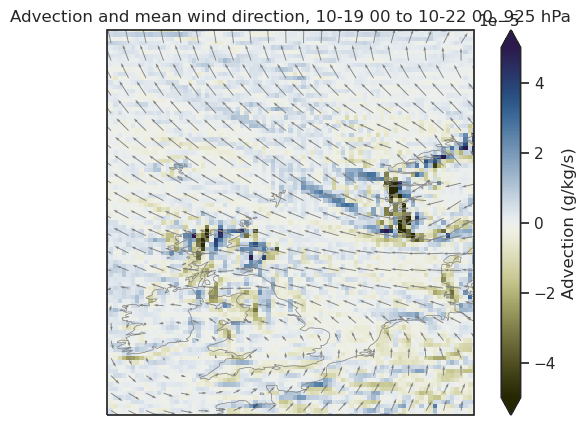

In [55]:
inidate = '2023-10-17'
time = '2023-10-20 09'

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(uk, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='gray', linewidth=0.5)

# Plot scalar advection
(adv['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])).plot(vmin=-0.5e-4, vmax=0.5e-4, 
                                                                                               cmap=cm.broc_r, 
                                                                                               ax=ax, 
                                                                                               transform=ccrs.PlateCarree(),
                                                                                               cbar_kwargs={"label": "Advection (g/kg/s)"})

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
          u['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
          v['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
          transform=ccrs.PlateCarree(), scale=20, color='gray')
plt.title(f'Advection and mean wind direction, 10-19 00 to 10-22 00, {level} hPa')

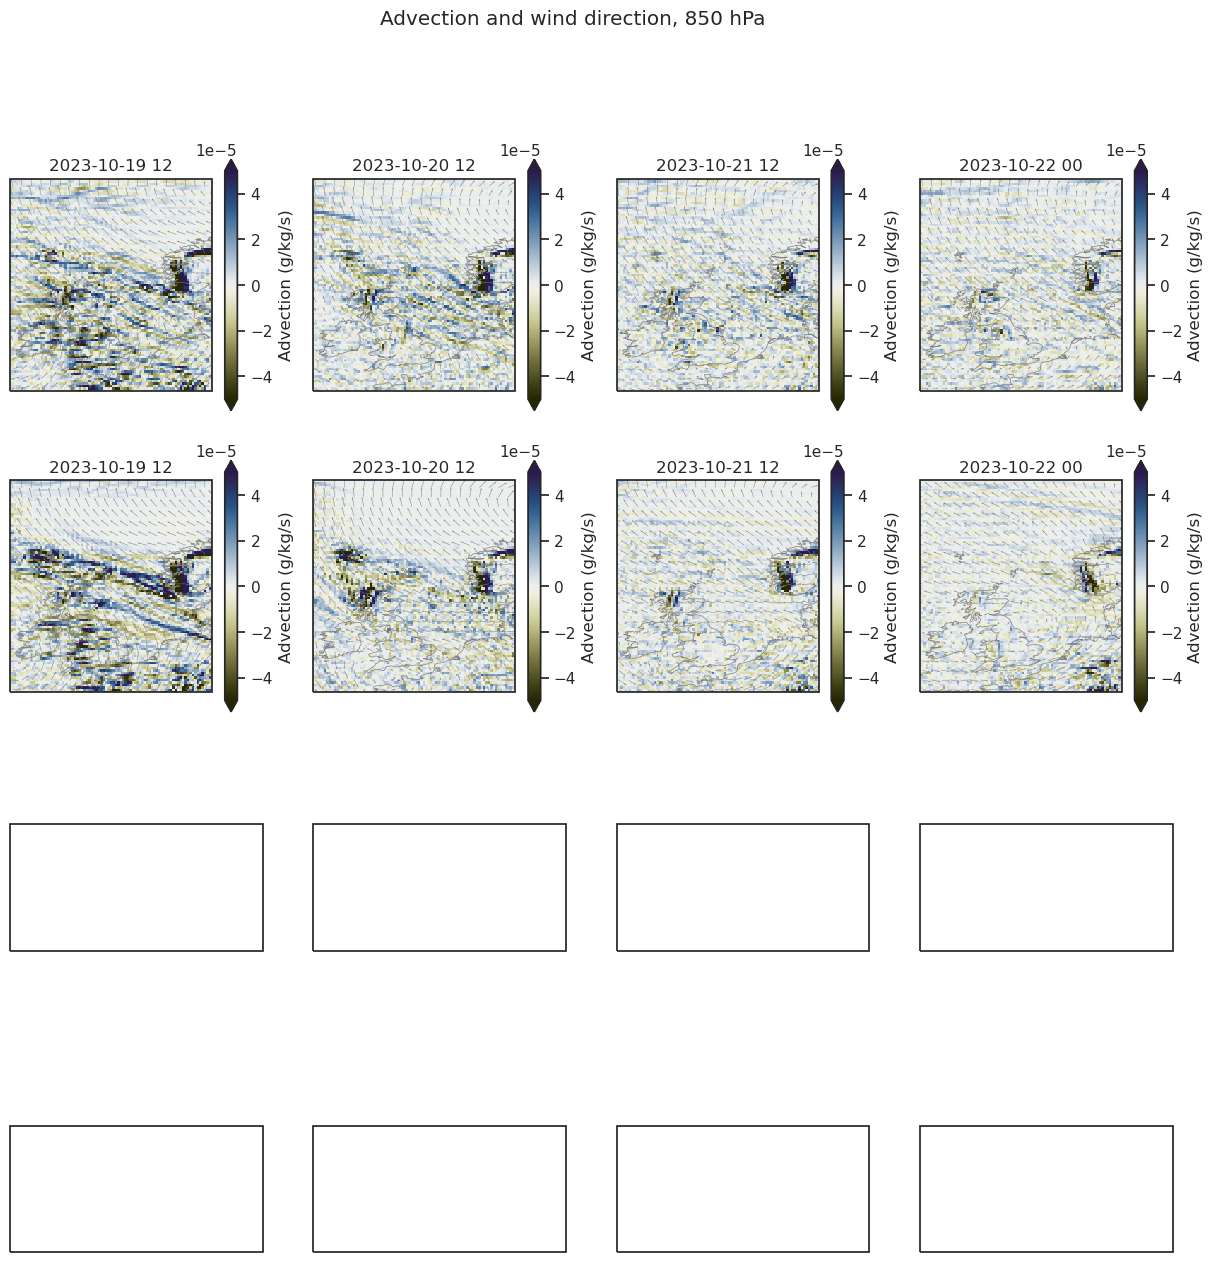

In [ ]:
level = 850

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]
inidates = ['2023-10-15', '2023-10-17']
times = ['2023-10-19 12', '2023-10-20 12', '2023-10-21 12', '2023-10-22 00']

fig, ax = plt.subplots(2, 4, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})

for ini, inidate in enumerate(inidates):
    for i, time in enumerate(times):
        ax[ini][i].set_extent(uk, crs=ccrs.PlateCarree())
        ax[ini][i].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='gray', linewidth=0.5)

        # Plot scalar advection
        (adv['curr'].sel(time=time, inidate=inidate).mean('number')).plot(vmin=-0.5e-4, vmax=0.5e-4, 
                                                                        cmap=cm.broc_r, 
                                                                        ax=ax[ini][i],
                                                                        transform=ccrs.PlateCarree(),
                                                                        cbar_kwargs={"label": "Advection (g/kg/s)"})

        # Plot wind vectors
        stride = 4
        llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
        ax[ini][i].quiver(llon, llat, 
                u['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
                v['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
                transform=ccrs.PlateCarree(), scale=20, color='gray')
        ax[ini][i].set_title(f'{time}')
plt.suptitle(f'Advection and wind direction, {level} hPa')

plt.savefig('figures/09_advection_curr_timeseries.png', dpi=600)
plt.savefig('figures/09_advection_curr_timeseries.pdf') 

# Surface advection in curr

In [36]:
def calc_surf_advection_q(ds, ds_sfc):
    '''
    Calculate scalar horizontal advection of q
    on a pressure level

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing u, v and q variables
    level : int, optional
        Pressure level to calculate advection, by default 850

    Returns
    -------
    xarray.DataArray
        Scalar advection
    '''
    # Calculate gradient of q
    level = 1000
    dqdlon = ds.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(ds.sel(level=level).latitude, ds.sel(level=level).longitude.values[:-2], ds.sel(level=level).latitude, ds.sel(level=level).longitude[2:])
    dqdlat = ds.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(ds.sel(level=level).latitude.values[:-2], ds.sel(level=level).longitude, ds.sel(level=level).latitude[2:], ds.sel(level=level).longitude)
    
    # Calculate advection
    adv = (ds_sfc.u10.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon) + (ds_sfc.v10.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return adv

In [37]:
# Calculate scalar surface advection
adv_sfc = {}
for experiment in experiments:
    adv_sfc[experiment] = calc_surf_advection_q(exp[experiment], exp_sfc[experiment]) 

# Calculate unit vector of wind
u_sfc = {}
v_sfc = {}
for experiment in experiments:
    u_sfc[experiment] = (exp_sfc[experiment].u10 / np.sqrt(exp_sfc[experiment].u10**2 + exp_sfc[experiment].v10**2)).isel(latitude=slice(1, -1), longitude=slice(1, -1))
    v_sfc[experiment] = (exp_sfc[experiment].v10 / np.sqrt(exp_sfc[experiment].u10**2 + exp_sfc[experiment].v10**2)).isel(latitude=slice(1, -1), longitude=slice(1, -1))

Text(0.5, 0.98, 'Advection and wind direction, 1000 hPa')

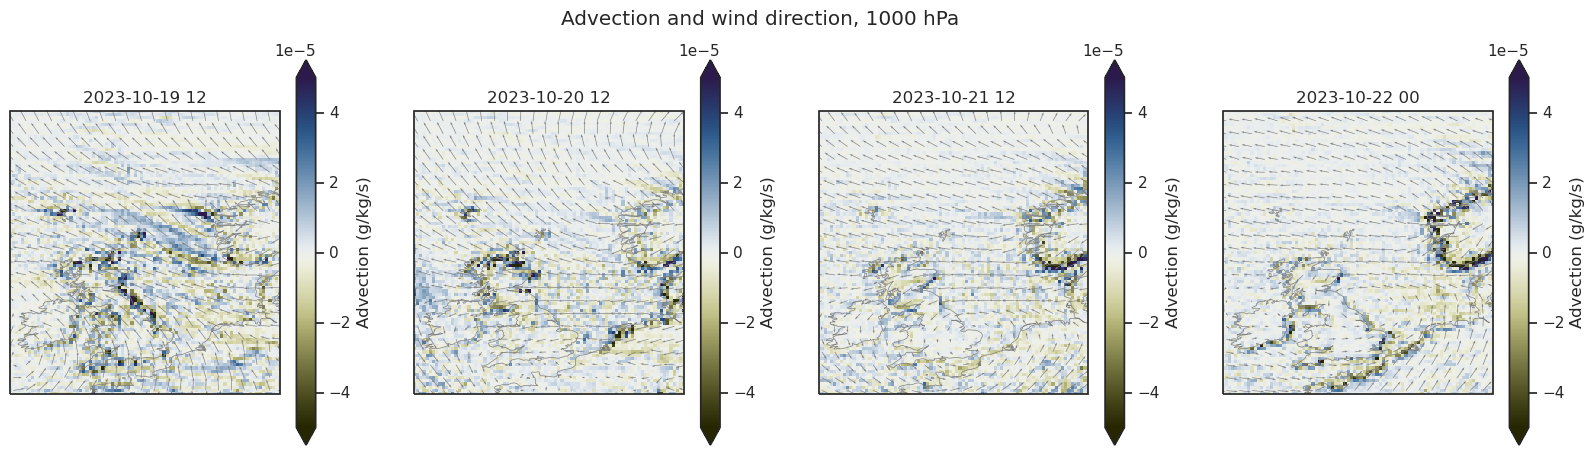

In [38]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 1000

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

times = ['2023-10-19 12', '2023-10-20 12', '2023-10-21 12', '2023-10-22 00']

fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for i, time in enumerate(times):
    ax[i].set_extent(uk, crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='gray', linewidth=0.5)

    # Plot scalar advection
    (adv_sfc['curr'].sel(time=time, inidate=inidate).mean('number')).plot(vmin=-5e-5, vmax=5e-5, 
                                                                    cmap=cm.broc_r, 
                                                                    ax=ax[i],
                                                                    transform=ccrs.PlateCarree(),
                                                                    cbar_kwargs={"label": "Advection (g/kg/s)"})

    # Plot wind vectors
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax[i].quiver(llon, llat, 
            u_sfc['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            v_sfc['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            transform=ccrs.PlateCarree(), scale=20, color='gray')
    ax[i].set_title(f'{time}')
plt.suptitle(f'Advection and wind direction, {level} hPa')

# Specific humidity timeseries

Text(0.5, 0.98, 'q and wind direction, 850 hPa')

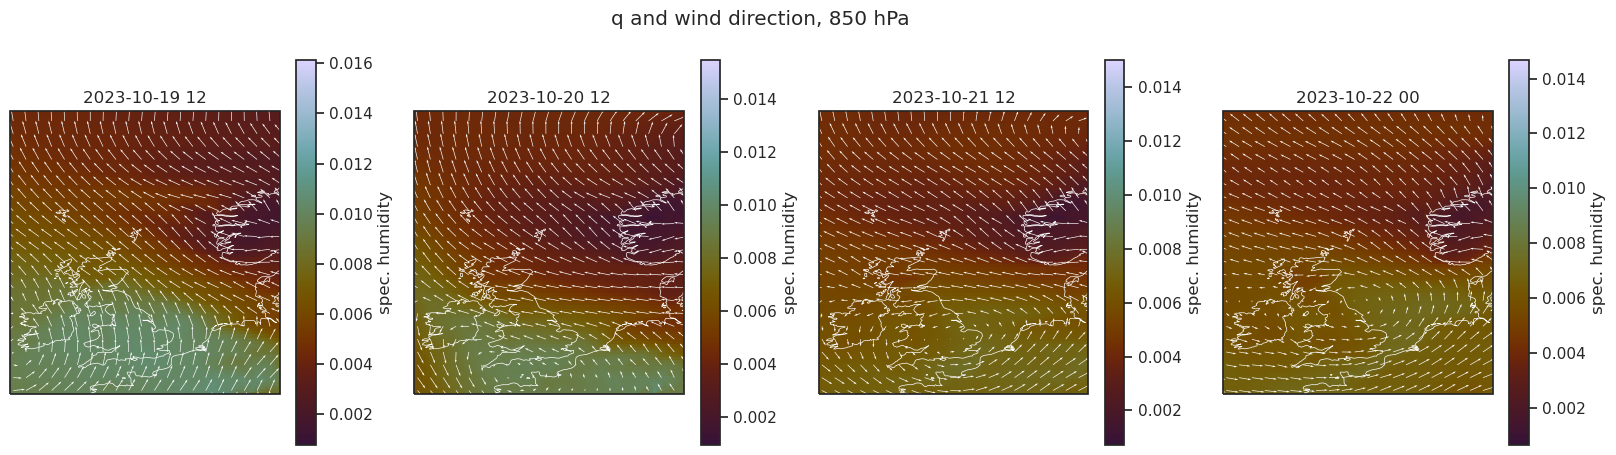

In [ ]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 850

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

times = ['2023-10-19 12', '2023-10-20 12', '2023-10-21 12', '2023-10-22 00']

fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for i, time in enumerate(times):
    ax[i].set_extent(uk, crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)

    # Plot scalar advection
    (exp['curr'].q.sel(time=time, inidate=inidate, level=1000).mean('number')).plot(cmap=cm.lapaz_r, 
                                                                    ax=ax[i],
                                                                    transform=ccrs.PlateCarree(),
                                                                    cbar_kwargs={"label": "spec. humidity"})

    # Plot wind vectors
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax[i].quiver(llon, llat, 
            u['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            v['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            transform=ccrs.PlateCarree(), scale=20, color='white')
    ax[i].set_title(f'{time}')
plt.suptitle(f'q and wind direction, {level} hPa')

Text(0.5, 0.98, 'q and wind direction, 1000 hPa')

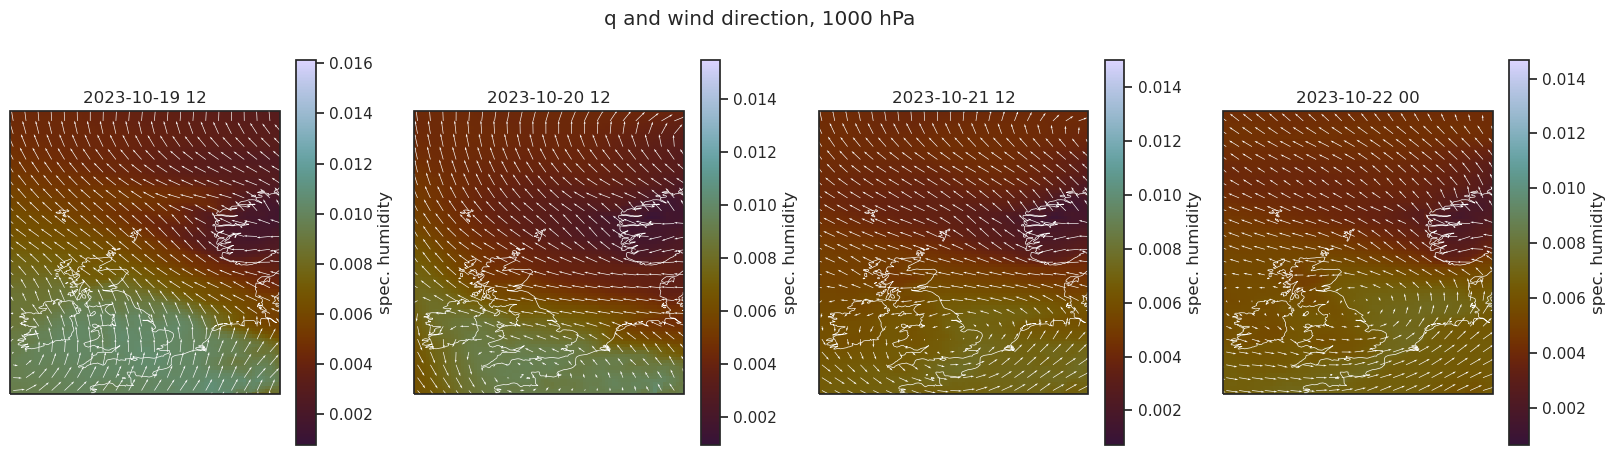

In [30]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 1000

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

times = ['2023-10-19 12', '2023-10-20 12', '2023-10-21 12', '2023-10-22 00']

fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for i, time in enumerate(times):
    ax[i].set_extent(uk, crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)

    # Plot scalar advection
    (exp['curr'].q.sel(time=time, inidate=inidate, level=1000).mean('number')).plot(cmap=cm.glasgow, 
                                                                    ax=ax[i],
                                                                    transform=ccrs.PlateCarree(),
                                                                    cbar_kwargs={"label": "spec. humidity"})

    # Plot wind vectors
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax[i].quiver(llon, llat, 
            u['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            v['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            transform=ccrs.PlateCarree(), scale=20, color='white')
    ax[i].set_title(f'{time}')
plt.suptitle(f'q and wind direction, {level} hPa')

# Compare experiments

In [9]:
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']

# Save data for plot
# adv_vals_dict = {exp_key: {ini_key: adv[exp_key].sel(time=slice(starttime, endtime), inidate=ini_key).mean(['number', 'time']).squeeze().values for ini_key in inidates} for exp_key in adv.keys()}
# u_vals_dict = {exp_key: {ini_key: u[exp_key].sel(time=slice(starttime, endtime), inidate=ini_key).mean(['number', 'time']).squeeze().values for ini_key in inidates} for exp_key in u.keys()}
# v_vals_dict = {exp_key: {ini_key: v[exp_key].sel(time=slice(starttime, endtime), inidate=ini_key).mean(['number', 'time']).squeeze().values for ini_key in inidates} for exp_key in v.keys()}
# adv_era5_vals = adv_era5.sel(time=slice(starttime, endtime)).mean('time').squeeze().values
# u_era5_vals = u_era5.sel(time=slice(starttime, endtime)).mean('time').squeeze().values
# v_era5_vals = v_era5.sel(time=slice(starttime, endtime)).mean('time').squeeze().values

# np.save('data/09_advection_vals.npy', adv_vals_dict)
# np.save('../data/09_u_vals.npy', u_vals_dict)
# np.save('../data/09_v_vals.npy', v_vals_dict)
# np.save('../data/09_advection_era5_vals.npy', adv_era5_vals)
# np.save('../data/09_u_era5_vals.npy', u_era5_vals)
# np.save('../data/09_v_era5_vals.npy', v_era5_vals)

In [10]:
data_saved = True

# Reload data for plot
adv_vals_dict = np.load('../data/09_advection_vals.npy', allow_pickle=True).item()
u_vals_dict = np.load('../data/09_u_vals.npy', allow_pickle=True).item()
v_vals_dict = np.load('../data/09_v_vals.npy', allow_pickle=True).item()
adv_era5_vals = np.load('../data/09_advection_era5_vals.npy')
u_era5_vals = np.load('../data/09_u_era5_vals.npy')
v_era5_vals = np.load('../data/09_v_era5_vals.npy')

In [ ]:
# if not data_saved: 
#     # figure and map setup
#     experiments = ['pi', 'curr', 'incr']
#     fs = 18
#     projection = ccrs.PlateCarree()

#     adv_min = 0
#     adv_max = 0.0003

#     fig = plt.figure(1, figsize=(15, 11))
#     lead_times = ['inidate 2023-10-15', 'inidate 2023-10-17']
#     inidates = ['2023-10-15', '2023-10-17']
#     starttime = '2023-10-19 00'
#     endtime = '2023-10-22 00'

#     # EPS data ------------------    

#     for i, inidate in enumerate(inidates):
#         for e, experiment in enumerate(experiments):
#             latitude = adv['curr'].latitude.values
#             longitude = adv['curr'].longitude.values

#             if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
#                 adv_vals = ((adv[experiment].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])) - (adv['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time']))).squeeze().values
#             else: 
#                 adv_vals = (adv['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])).values

#             ax = plt.subplot(3,3, i+1+e*3,projection = projection)
#             ax.set_extent(uk, projection)
#             ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'white', zorder = 14)

#             # advection as shading
#             if experiment =='curr':
#                 clevs_adv = np.linspace(adv_min, adv_max, 11)  # 17
#                 cf = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.devon,
#                                 transform=projection, zorder = 10, extend = 'both')
#             else: 
#                 clevs_adv = np.linspace(adv_max*(-0.1), adv_max*0.1, 10)
#                 cf_diff = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
#                                     transform=projection, zorder = 10, extend = 'both')
            
#             # Plot wind vectors
#             latitude = u[experiment].latitude.values
#             longitude = u[experiment].longitude.values
#             stride = 4
#             llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
#             ax.quiver(llon, llat, 
#                     u[experiment].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
#                     v[experiment].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
#                     transform=ccrs.PlateCarree(), scale=20, color='white')

#             # rectangle for Aberdeenshire box
#             rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
#                                         edgecolor='k', 
#                                         facecolor='none',
#                                         transform=projection)
#             ax.add_patch(rectangle)
#             rectangle.set_zorder(17)

#     # ERA5 or analysis data ----------------------
#     latitude = adv_era5.latitude.values
#     longitude = adv_era5.longitude.values

#     adv_vals = (adv_era5.sel(time=slice(starttime, endtime)).mean('time')).values
#     ax = plt.subplot(3,3,6,projection = projection)
#     ax.set_extent(uk, projection)
#     ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'white', zorder = 14)
#     ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

#     # advection as shading
#     clevs_adv = np.linspace(adv_min, adv_max, 11)  # 17
#     cf = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.devon,
#                     transform=projection, zorder = 10, extend = 'both')

#     # Plot wind vectors
#     stride = 4
#     latitude = u_era5.latitude.values
#     longitude = u_era5.longitude.values
#     llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
#     ax.quiver(llon, llat, 
#             u_era5.sel(time=slice(starttime, endtime)).mean('time')[::stride, ::stride], 
#             v_era5.sel(time=slice(starttime, endtime)).mean('time')[::stride, ::stride], 
#             transform=ccrs.PlateCarree(), scale=20, color='white')

#     # rectangle for Aberdeenshire box
#     rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
#                                     edgecolor='k', 
#                                     facecolor='none',
#                                     transform=projection)
#     ax.add_patch(rectangle)
#     rectangle.set_zorder(17)

#     # Other figure settings -----------------
#     ax = plt.subplot(3,3,3)
#     ax.axis('off')  # removes subplot frame
#     cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
#     cbar = fig.colorbar(cf, cax=cax, label='advection (g/kg/s)', extend = 'max', shrink=0.8)
#     cbar.set_label(label='advection (g/kg/s)', size=fs)
#     cbar.ax.tick_params(labelsize=fs-3)

#     cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
#     cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='advection difference (g/kg/s)', extend = 'both', shrink=0.8)
#     cbar_diff.set_label(label='advection difference (g/kg/s)', size=fs)
#     cbar_diff.ax.tick_params(labelsize=fs-3)
#     plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
#     plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
#     plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
#     plt.suptitle(f'Advection at {level}', size = fs)
#     plt.tight_layout()

#     plt.savefig('figures/09_advection_comparison.png', dpi=600)
#     plt.savefig('figures/09_advection_comparison.pdf')   

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


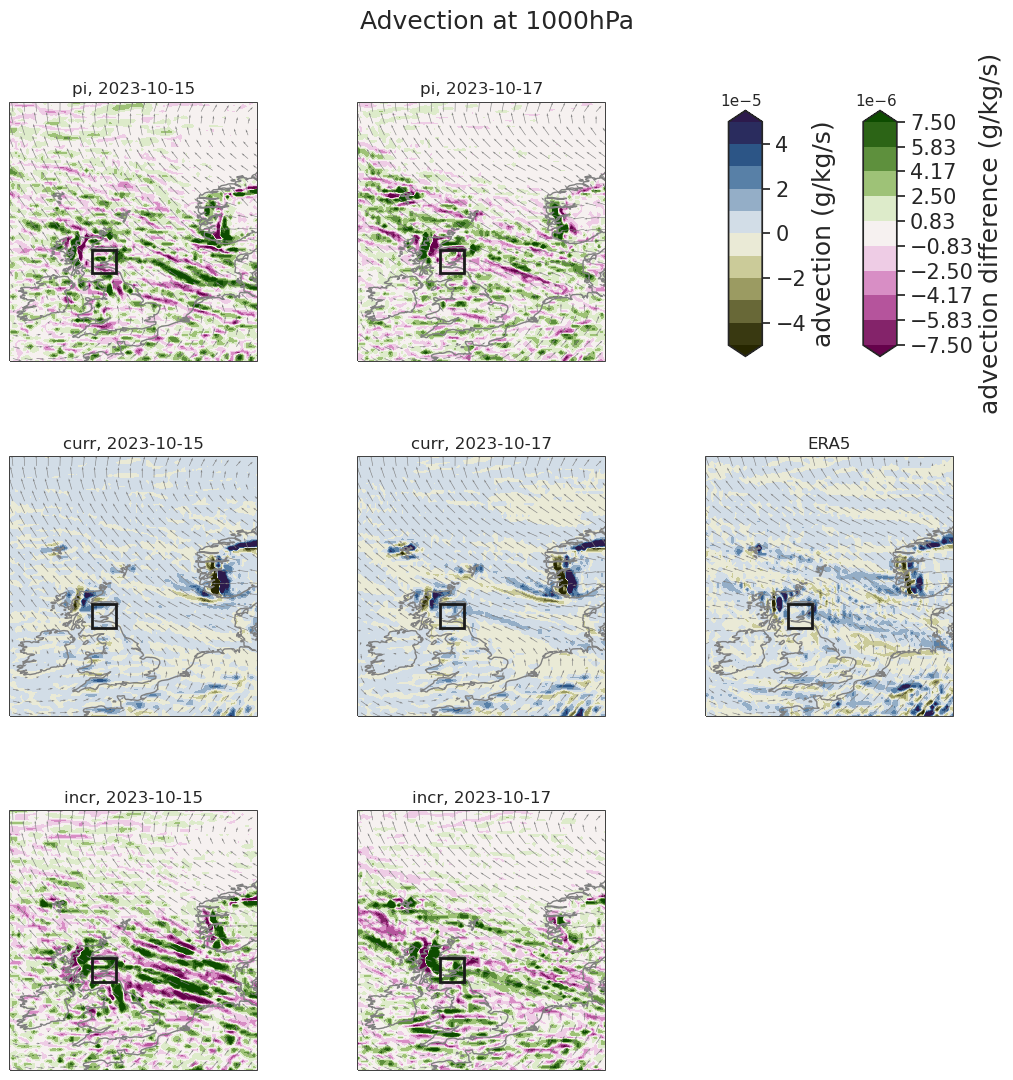

In [39]:
if data_saved: 
    # figure and map setup
    experiments = ['pi', 'curr', 'incr']
    fs = 18
    projection = ccrs.PlateCarree()

    adv_min = -0.00005
    adv_max = 0.00005

    fig = plt.figure(1, figsize=(11, 11))
    lead_times = ['inidate 2023-10-15', 'inidate 2023-10-17']
    inidates = ['2023-10-15', '2023-10-17']
    starttime = '2023-10-19 00'
    endtime = '2023-10-22 00'

    # EPS data ------------------    

    for i, inidate in enumerate(inidates):
        for e, experiment in enumerate(experiments):
            latitude = adv['curr'].latitude.values
            longitude = adv['curr'].longitude.values

            if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
                adv_vals = adv_vals_dict[experiment][inidate] - adv_vals_dict['curr'][inidate]
            else: 
                adv_vals = adv_vals_dict[experiment][inidate]

            ax = plt.subplot(3,3, i+1+e*3,projection = projection)
            ax.set_extent(uk, projection)
            ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)

            # advection as shading
            if experiment =='curr':
                clevs_adv = np.linspace(adv_min, adv_max, 11)  # 17
                cf = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.broc_r,
                                transform=projection, zorder = 10, extend = 'both')
            else: 
                clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)
                cf_diff = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                                    transform=projection, zorder = 10, extend = 'both')
            
            # Plot wind vectors
            latitude = u[experiment].latitude.values
            longitude = u[experiment].longitude.values
            stride = 4
            llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
            ax.quiver(llon, llat, 
                    u_vals_dict[experiment][inidate][::stride, ::stride], 
                    v_vals_dict[experiment][inidate][::stride, ::stride], 
                    zorder=11,
                    transform=ccrs.PlateCarree(), scale=20, color='gray')

            # rectangle for Aberdeenshire box
            rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                        edgecolor='k', 
                                        facecolor='none',
                                        transform=projection)
            ax.add_patch(rectangle)
            rectangle.set_zorder(17)
            ax.set_title(f'{experiment}, {inidate}')

    # ERA5 or analysis data ----------------------
    latitude = adv_era5.latitude.values
    longitude = adv_era5.longitude.values

    adv_vals = adv_era5_vals
    ax = plt.subplot(3,3,6,projection = projection)
    ax.set_extent(uk, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)

    # advection as shading
    clevs_adv = np.linspace(adv_min, adv_max, 11)  # 17
    cf = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.broc_r,
                    transform=projection, zorder = 10, extend = 'both')

    # Plot wind vectors
    stride = 4
    latitude = u_era5.latitude.values
    longitude = u_era5.longitude.values
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax.quiver(llon, llat, 
            u_era5_vals[::stride, ::stride], 
            v_era5_vals[::stride, ::stride], 
            zorder=11,
            transform=ccrs.PlateCarree(), scale=20, color='gray')

    # rectangle for Aberdeenshire box
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                    edgecolor='k', 
                                    facecolor='none',
                                    transform=projection)
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)
    ax.set_title('ERA5')

    # Other figure settings -----------------
    ax = plt.subplot(3,3,3)
    ax.axis('off')  # removes subplot frame
    cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
    cbar = fig.colorbar(cf, cax=cax, label='advection (g/kg/s)', extend = 'max', shrink=0.8)
    cbar.set_label(label='advection (g/kg/s)', size=fs)
    cbar.ax.tick_params(labelsize=fs-3)

    cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
    cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='advection difference (g/kg/s)', extend = 'both', shrink=0.8)
    cbar_diff.set_label(label='advection difference (g/kg/s)', size=fs)
    cbar_diff.ax.tick_params(labelsize=fs-3)
    # plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
    # plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
    # plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
    plt.suptitle(f'Advection at {level}hPa', size = fs)
    plt.tight_layout()

    plt.savefig('figures/09_advection_comparison.png', dpi=600)
    plt.savefig('figures/09_advection_comparison.pdf')   

<Figure size 1500x500 with 0 Axes>

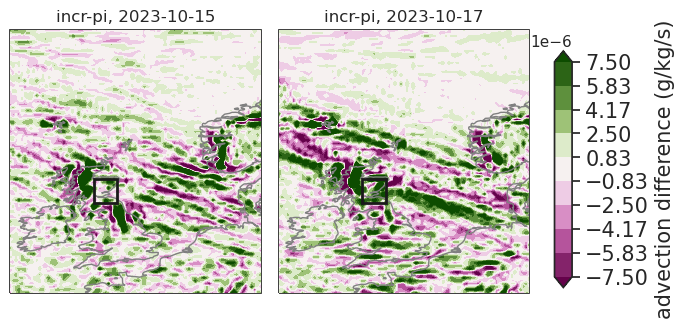

In [26]:
# Difference between pi and incr
fs = 18
projection = ccrs.PlateCarree()

adv_min = 0
adv_max = 0.00005

fig = plt.figure(1, figsize=(15, 5))
lead_times = ['inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

fig= plt.figure(figsize=(7, 5))

for i, inidate in enumerate(inidates):
    ax = plt.subplot(1,2, i+1,projection = projection)
    ax.set_extent(uk, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)

    # advection difference
    latitude = adv['curr'].latitude.values
    longitude = adv['curr'].longitude.values
    adv_vals = adv_vals_dict['incr'][inidate] - adv_vals_dict['pi'][inidate]

    # advection as shading
    clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)
    cf_diff = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                        transform=projection, zorder = 10, extend = 'both')

    # # Plot wind vectors
    # latitude = u[experiment].latitude.values
    # longitude = u[experiment].longitude.values
    # stride = 4
    # llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    # ax.quiver(llon, llat, 
    #         u_vals_dict[experiment][inidate][::stride, ::stride], 
    #         v_vals_dict[experiment][inidate][::stride, ::stride], 
    #         zorder=11,
    #         transform=ccrs.PlateCarree(), scale=20, color='gray')

    # rectangle for Aberdeenshire box
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)
    ax.set_title(f'incr-pi, {inidate}')

cax_diff = ax.inset_axes([1.1, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='advection difference (g/kg/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='advection difference (g/kg/s)', size=fs-3)
cbar_diff.ax.tick_params(labelsize=fs-3)

plt.tight_layout()

# Dynamic v thermodynamic decomposition

In [9]:
def calc_dynamic_adv(dict_ds, experiment, level=850): 

    q_bar = dict_ds['curr']
    u_prime = dict_ds[experiment] - dict_ds['curr']

    # Calculate gradient of q
    dqdlon =q_bar.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(q_bar.sel(level=level).latitude, q_bar.sel(level=level).longitude.values[:-2], q_bar.sel(level=level).latitude, q_bar.sel(level=level).longitude[2:])
    dqdlat = q_bar.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(q_bar.sel(level=level).latitude.values[:-2], q_bar.sel(level=level).longitude, q_bar.sel(level=level).latitude[2:], q_bar.sel(level=level).longitude)
    
    # Calculate advection
    adv = (u_prime.sel(level=level).u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon) + (u_prime.sel(level=level).v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return adv

In [10]:
def calc_thermodynamic_adv(dict_ds, experiment, level=850): 

    q_prime = dict_ds[experiment] - dict_ds['curr']
    u_bar = dict_ds['curr'] # all variables entailed so no need for v_bar here

    # Calculate gradient of q
    dqdlon =q_prime.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(q_prime.sel(level=level).latitude, q_prime.sel(level=level).longitude.values[:-2], q_prime.sel(level=level).latitude, q_prime.sel(level=level).longitude[2:])
    dqdlat = q_prime.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(q_prime.sel(level=level).latitude.values[:-2], q_prime.sel(level=level).longitude, q_prime.sel(level=level).latitude[2:], q_prime.sel(level=level).longitude)
    
    # Calculate advection
    adv = (u_bar.sel(level=level).u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon) + (u_bar.sel(level=level).v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return adv

In [11]:
adv_dynamic = {}
adv_thermodynamic = {}
level = 925

for experiment in ['pi', 'incr']: 
    adv_dynamic[experiment] = calc_dynamic_adv(exp, experiment, level=level)
    adv_thermodynamic[experiment] = calc_thermodynamic_adv(exp, experiment, level=level)

In [12]:
# # Save data for plot
# adv_dynamic_vals_dict = {exp_key: {ini_key: adv_dynamic[exp_key].sel(time=slice(starttime, endtime), inidate=ini_key).mean(['number', 'time']).squeeze().values for ini_key in ['2023-10-15', '2023-10-17']} for exp_key in adv_dynamic.keys()}
# adv_thermodynamic_vals_dict = {exp_key: {ini_key: adv_thermodynamic[exp_key].sel(time=slice(starttime, endtime), inidate=ini_key).mean(['number', 'time']).squeeze().values for ini_key in ['2023-10-15', '2023-10-17']} for exp_key in adv_thermodynamic.keys()}

# np.save(f'../data/09_advection_dynamic_vals_level{level}.npy', adv_dynamic_vals_dict)
# np.save(f'../data/09_advection_thermodynamic_vals_level{level}.npy', adv_thermodynamic_vals_dict)

In [66]:
# Load data for plot
level = 850
adv_dynamic_vals_dict = np.load(f'../data/09_advection_dynamic_vals_level{level}.npy', allow_pickle=True).item()
adv_thermodynamic_vals_dict = np.load(f'../data/09_advection_thermodynamic_vals_level{level}.npy', allow_pickle=True).item()

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


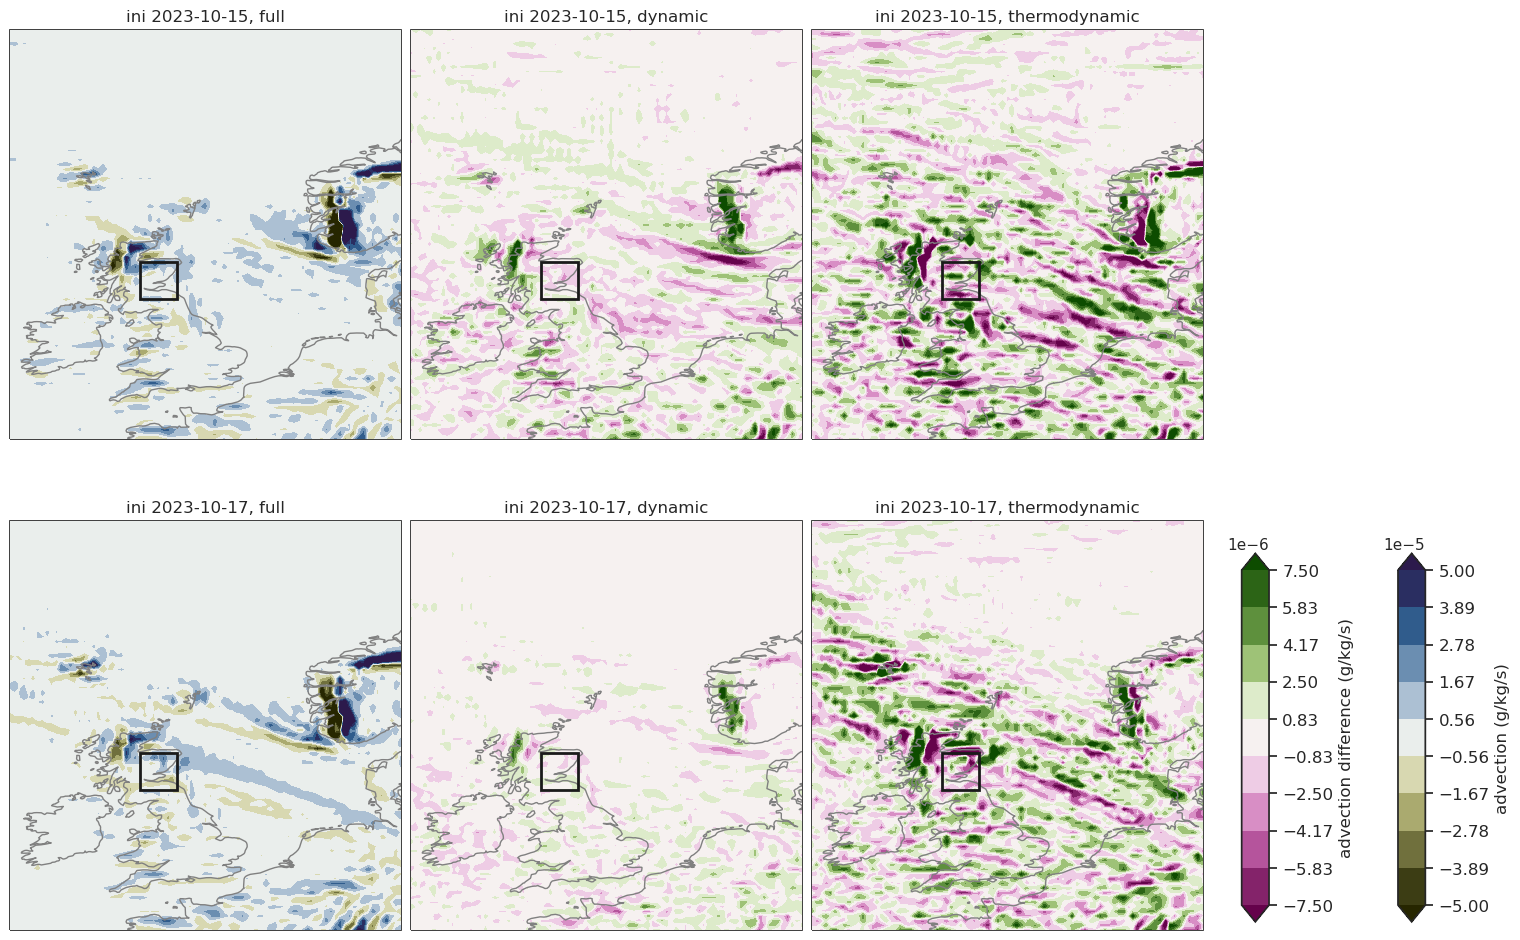

In [67]:
# pi: full, dynamic, thermodynamic for two inidates
inidates = ['2023-10-15', '2023-10-17']
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
fs = 15

fig = plt.figure(1, figsize=(15, 10))
projection = ccrs.PlateCarree()
adv_min = -0.00005
adv_max = 0.00005
clevs_adv = np.linspace(adv_min, adv_max, 10)

latitude = adv['curr'].latitude.values
longitude = adv['curr'].longitude.values

for i, inidate in enumerate(inidates):

    # full change in advection
    clevs_adv = np.linspace(adv_min, adv_max, 10)
    ax1 = plt.subplot(2,3, 1+i*3,projection = projection)
    ax1.set_extent(uk, projection)
    adv_vals = adv_vals_dict['pi'][inidate]
    cf = ax1.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.broc_r,
                      transform=projection, zorder = 10, extend = 'both')
    ax1.set_title(f'ini {inidate}, full')
    ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax1.add_patch(rectangle)
    rectangle.set_zorder(17)

    # dynamic change in advection
    clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)    
    ax2 = plt.subplot(2,3, 2+i*3,projection = projection)
    ax2.set_extent(uk, projection)
    adv_vals = adv_dynamic_vals_dict['pi'][inidate]
    cf_diff = ax2.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                          transform=projection, zorder = 10, extend = 'both')
    ax2.set_title(f'ini {inidate}, dynamic')
    ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax2.add_patch(rectangle)
    rectangle.set_zorder(17)

    # thermodynamic change in advection
    clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)
    ax3 = plt.subplot(2,3, 3+i*3,projection = projection)
    ax3.set_extent(uk, projection)
    adv_vals = adv_thermodynamic_vals_dict['pi'][inidate]
    cf_diff = ax3.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                          transform=projection, zorder = 10, extend = 'both')
    ax3.set_title(f'ini {inidate}, thermodynamic')
    ax3.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax3.add_patch(rectangle)
    rectangle.set_zorder(17)

# colourbars
cax_diff = ax3.inset_axes([1.1, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='advection difference (g/kg/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='advection difference (g/kg/s)', size=fs-3)
cbar_diff.ax.tick_params(labelsize=fs-3)

cax = ax3.inset_axes([1.5, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='advection (g/kg/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='advection (g/kg/s)', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

plt.tight_layout()
# plt.suptitle('Advection difference at 850hPa for PI')
plt.savefig(f'figures/09_advection_pi_dyn-therm_level{level}.png', dpi=600)
plt.savefig(f'figures/09_advection_pi_dyn-therm_level{level}.pdf')


/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


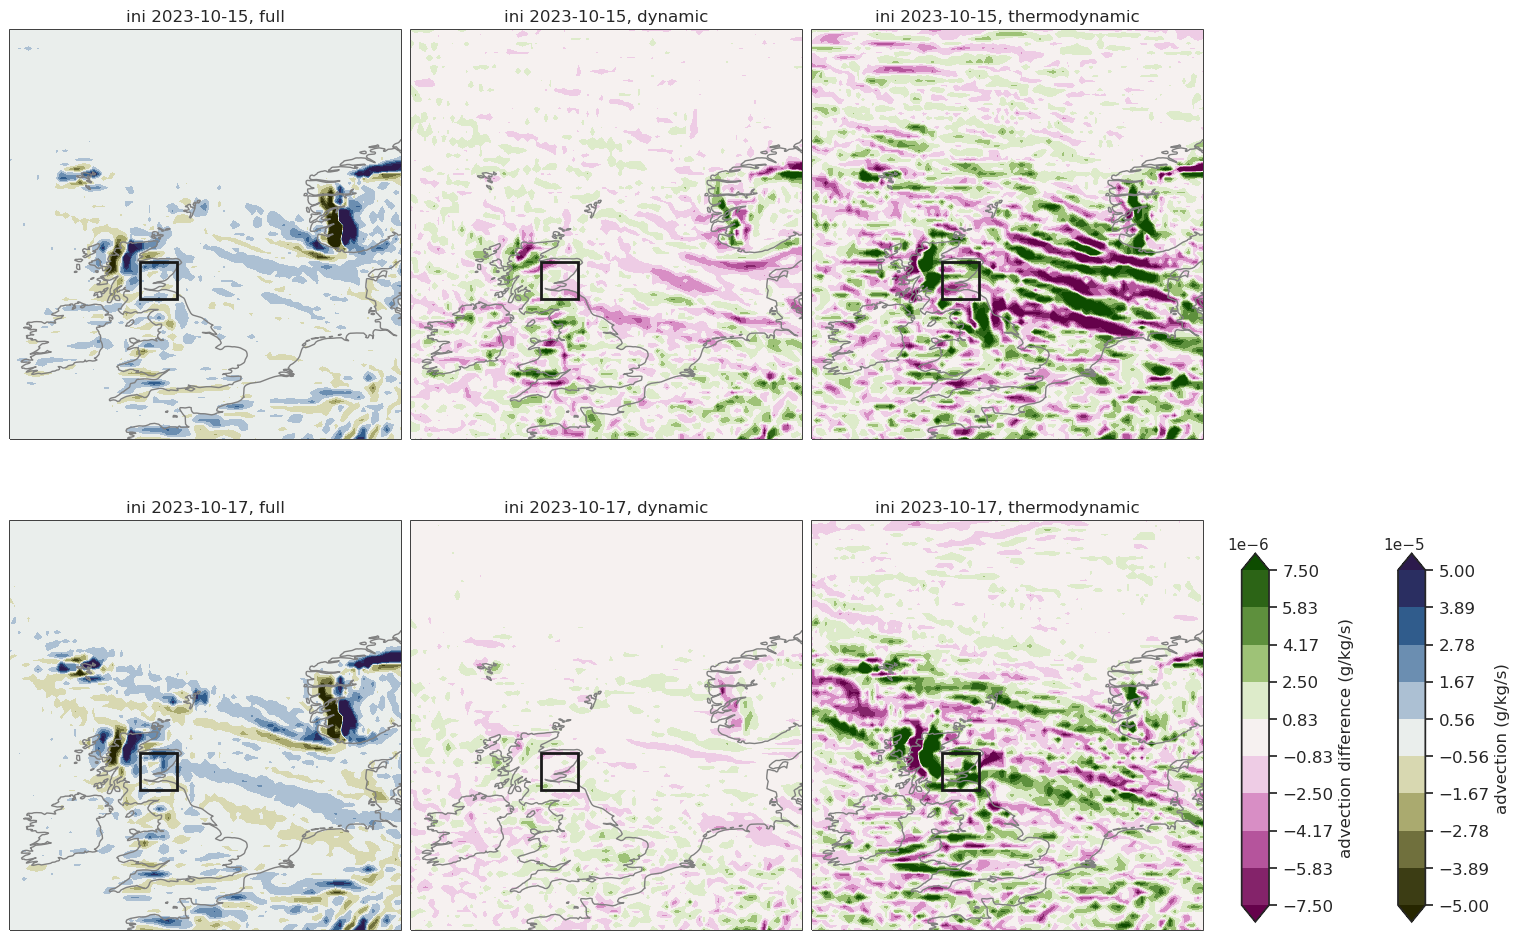

In [68]:
# incr: full, dynamic, thermodynamic for two inidates
inidates = ['2023-10-15', '2023-10-17']
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
fs = 15

fig = plt.figure(1, figsize=(15, 10))
projection = ccrs.PlateCarree()
adv_min = -0.00005
adv_max = 0.00005
clevs_adv = np.linspace(adv_min, adv_max, 10)

latitude = adv['curr'].latitude.values
longitude = adv['curr'].longitude.values

for i, inidate in enumerate(inidates):

    # full change in advection
    clevs_adv = np.linspace(adv_min, adv_max, 10)
    ax1 = plt.subplot(2,3, 1+i*3,projection = projection)
    ax1.set_extent(uk, projection)
    adv_vals = adv_vals_dict['incr'][inidate]
    cf = ax1.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.broc_r,
                      transform=projection, zorder = 10, extend = 'both')
    ax1.set_title(f'ini {inidate}, full')
    ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax1.add_patch(rectangle)
    rectangle.set_zorder(17)

    # dynamic change in advection
    clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)    
    ax2 = plt.subplot(2,3, 2+i*3,projection = projection)
    ax2.set_extent(uk, projection)
    adv_vals = adv_dynamic_vals_dict['incr'][inidate]
    cf_diff = ax2.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                          transform=projection, zorder = 10, extend = 'both')
    ax2.set_title(f'ini {inidate}, dynamic')
    ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax2.add_patch(rectangle)
    rectangle.set_zorder(17)

    # thermodynamic change in advection
    clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)
    ax3 = plt.subplot(2,3, 3+i*3,projection = projection)
    ax3.set_extent(uk, projection)
    adv_vals = adv_thermodynamic_vals_dict['incr'][inidate]
    cf_diff = ax3.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                          transform=projection, zorder = 10, extend = 'both')
    ax3.set_title(f'ini {inidate}, thermodynamic')
    ax3.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax3.add_patch(rectangle)
    rectangle.set_zorder(17)

# colourbars
cax_diff = ax3.inset_axes([1.1, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='advection difference (g/kg/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='advection difference (g/kg/s)', size=fs-3)
cbar_diff.ax.tick_params(labelsize=fs-3)

cax = ax3.inset_axes([1.5, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='advection (g/kg/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='advection (g/kg/s)', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

plt.tight_layout()
# plt.suptitle('Advection difference at 850hPa for INCR')
plt.savefig(f'figures/09_advection_incr_dyn-therm_level{level}.png', dpi=600)
plt.savefig(f'figures/09_advection_incr_dyn-therm_level{level}.pdf')

# TIP: Let the eye do the differentiation

In [9]:
def calc_dynamic_qu(dict_ds, experiment, level=850): 

    q_bar = dict_ds['curr']
    u_prime = dict_ds[experiment] - dict_ds['curr']

    # Calculate q x u
    qu = (u_prime.sel(level=level).u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * q_bar.q.sel(level=level)) + (u_prime.sel(level=level).v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return qu

# Vertically averaged moisture advection

In [10]:
def calc_advection_q_all(ds):
    '''
    Calculate scalar horizontal advection of q
    on a pressure level

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing u, v and q variables
    level : int, optional
        Pressure level to calculate advection, by default 850

    Returns
    -------
    xarray.DataArray
        Scalar advection
    '''
    # Calculate gradient of q
    dqdlon =ds.q.diff(n=2, dim='longitude') / bb.met.Met.haversine(ds.latitude, ds.longitude.values[:-2], ds.latitude, ds.longitude[2:])
    dqdlat = ds.q.diff(n=2, dim='latitude') / bb.met.Met.haversine(ds.latitude.values[:-2], ds.longitude, ds.latitude[2:], ds.longitude)
    
    # Calculate advection
    adv = (ds.u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon) + (ds.v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return adv

In [11]:
def vert_average_q_advection(ds, upper=250, lower=1000):
    
    # calculate moisture advection for all levels
    ds_levels = ds.copy(deep=True).sel(level=slice(upper, lower))
    ds_levels['q_advection'] = calc_advection_q_all(ds_levels)

    # Compute the pressure thickness (ΔP) between levels
    # The last dimension should be the pressure dimension
    delta_p = ds_levels.level.diff('level').rename('delta_p')

    # Align ΔP with the original dataset (it will be one less in size)
    delta_p = delta_p.assign_coords(p=ds_levels['level'].isel(level=slice(1, None)))

    # Compute the mass-weighted moisture advection
    weighted_vdq = ds_levels['q_advection'].isel(level=slice(1, None)) * delta_p

    # Compute the mass-weighted average
    mass_weighted_average = (weighted_vdq.sum(dim='level') / delta_p.sum(dim='level')).rename('mass_weighted_vdq')

    # Add the result to your dataset
    ds['mass_weighted_vdq'] = mass_weighted_average

    return ds

In [12]:
# test the function
test = vert_average_q_advection(exp['pi'])
test

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 163
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 287
  **blockwise_kwargs,


<xarray.Dataset>
Dimensions:            (time: 97, inidate: 4, longitude: 289, latitude: 163, level: 13, number: 50)
Coordinates:
  * time               (time) datetime64[ns] 2023-10-11 ... 2023-10-23
  * inidate            (inidate) datetime64[ns] 2023-10-11 ... 2023-10-17
  * longitude          (longitude) float32 -27.0 -26.75 -26.5 ... 44.75 45.0
  * latitude           (latitude) float32 73.5 73.25 73.0 ... 33.5 33.25 33.0
  * level              (level) int32 10 50 100 200 250 ... 600 700 850 925 1000
  * number             (number) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables:
    z                  (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    t                  (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    q                  (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    w                  (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    vo                 (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    d                  (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    u                  (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    v                  (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    r                  (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    mass_weighted_vdq  (time, inidate, number, latitude, longitude) float64 dask.array<chunksize=(2, 1, 50, 1, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-22 20:26:44 GMT by grib_to_netcdf-2.33.2: /opt/ecmw...

In [13]:
test2 = test.mass_weighted_vdq.sel(time=slice('2023-10-19 00', '2023-10-22 00'), inidate='2023-10-15', number=1).mean(dim='time')

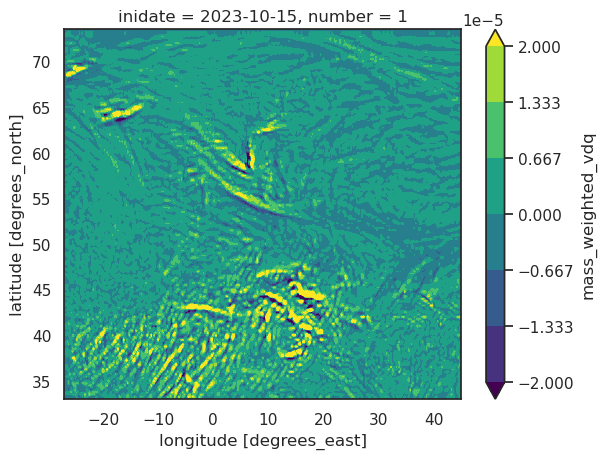

In [15]:
test2.plot.contourf(vmin=-0.00002, vmax=0.00002)